# Computing dead time 2 source method

Techniques for Nuclear and Particle Physics Experiments

A How-to Approach

Authors: Leo, William R.

We measure rate1 rate2 and rate12

$n1 = \frac{R1}{1-R1\tau}, n2 = \frac{R2}{1-R2\tau}$
$n1+n2 = \frac{R12}{1-R12\tau}$

this then smplifies to:

$\tau = \frac{R1R2 - [R1R2(R12-R1)(R12-R2)]^{1/2}}{R1R2R12}$


In [23]:
%matplotlib inline

from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as mc
import spacepy.toolbox as tb
import spacepy.plot as spp
import tqdm
from scipy import stats
import seaborn as sns
sns.set()


%matplotlib inline

## Generate some data

In [78]:
np.random.seed(8675309)

strength1 = 100
strength2 = 70

n_exp = 10

R1 = np.random.poisson(strength1, size=n_exp)
R2 = np.random.poisson(strength2, size=n_exp)
R12 = np.random.poisson(strength1+strength2, size=n_exp)
Rate = np.vstack((R1, R2, R12))
print(Rate)
print(Rate.shape)

[[110  96  97  91 103  95 107 118  86  87]
 [ 57  82  66  63  82  60  77  68  71  74]
 [192 154 177 180 165 162 181 166 178 193]]
(3, 10)


In [89]:
print(Rate[0])
print(Rate[1])
print(Rate[2])

[110  96  97  91 103  95 107 118  86  87]
[57 82 66 63 82 60 77 68 71 74]
[192 154 177 180 165 162 181 166 178 193]


In [79]:
print(R1, R2, R12)
print(R1*R2-np.sqrt(R1*R2*(R12-R1)*(R12-R2))/(R1*R2*R12))

[110  96  97  91 103  95 107 118  86  87] [57 82 66 63 82 60 77 68 71 74] [192 154 177 180 165 162 181 166 178 193]
[ 6269.99307948  7871.99527048  6401.99334611  5732.99251271  8445.9952693
  5699.99324096  8238.9946603   8023.99538757  6105.99286675  6437.9927474 ]


In [80]:
def tau_fn(R1, R2, R12):
    return R1*R2-np.sqrt(R1*R2*(R12-R1)*(R12-R2))/(R1*R2*R12)
print(tau_fn(R1, R2, R12))

[ 6269.99307948  7871.99527048  6401.99334611  5732.99251271  8445.9952693
  5699.99324096  8238.9946603   8023.99538757  6105.99286675  6437.9927474 ]


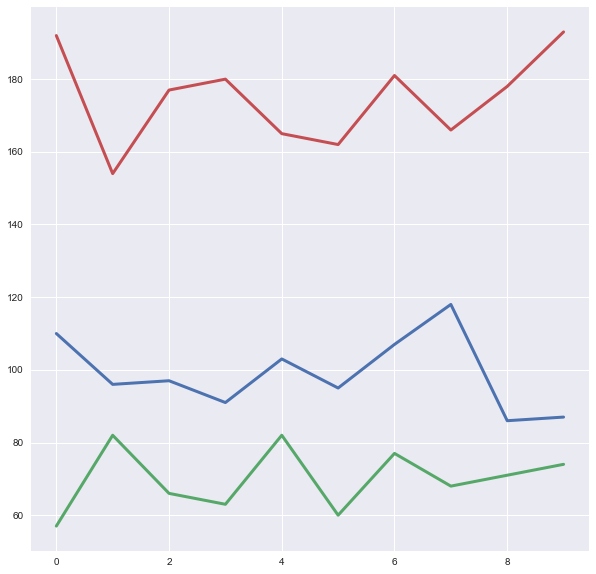

In [50]:
matplotlib.pyplot.rc('figure', figsize=(10,10))
matplotlib.pyplot.rc('lines', lw=3)


plt.plot(Rate.T)


# So what are the errors in each measurement?

In [90]:
with mc.Model() as model:
    mu1 = mc.Uniform('mu1', 0, 1000) # true counting rate
    mu2 = mc.Uniform('mu2', 0, 1000) # true counting rate
    mu12 = mc.Uniform('mu12', 0, 1000) # true counting rate
    R1 = mc.Poisson('R1', mu=mu1, observed=Rate[0])  # measured
    R2 = mc.Poisson('R2', mu=mu2, observed=Rate[1])  # measured
    R12 = mc.Poisson('R12', mu=mu12, observed=Rate[2])  # measured
    tau = mc.Deterministic('tau', tau_fn(R1, R2, R12))
    
    start = mc.find_MAP()
    trace = mc.sample(10000, start=start, njobs=4)

INFO (theano.gof.compilelock): Refreshing lock /Users/balarsen/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.2-64/lock_dir/lock


Optimization terminated successfully.
         Current function value: 118.670037
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 142.68:   7%|▋         | 13178/200000 [00:04<01:09, 2704.99it/s]
Convergence archived at 13200
Interrupted at 13,200 [6%]: Average Loss = 1,623
100%|██████████| 10500/10500 [00:12<00:00, 818.66it/s]


In [91]:
mc.summary(trace)


mu1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  99.094           3.137            0.014            [93.019, 105.288]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  93.026         96.961         99.056         101.184        105.299


mu2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  70.097           2.647            0.011            [65.004, 75.330]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  65.061         68.275         70.050         71.874         75.405


mu12:

  Mean             SD               MC Error         95% HPD interval
  ----------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132503ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x132c512e8>]], dtype=object)

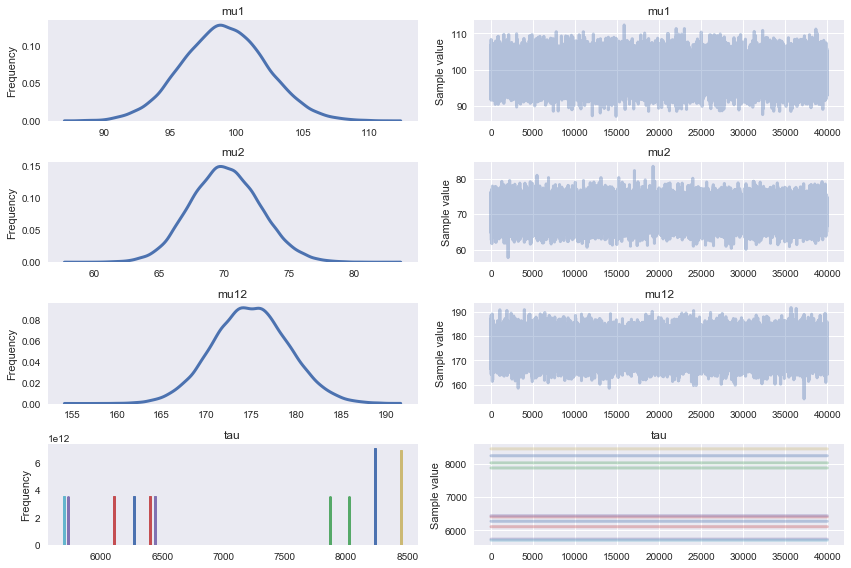

In [92]:
mc.traceplot(trace, combined=True)

In [84]:
tau_fn(trace['R1'][100:110], trace['R2'][100:110], trace['R12'][100:110])

KeyError: 'Unknown variable R1'